# Transfer Learning con MobileNetV3 para Clasificación de Frutas y Verduras

## Información del Proyecto

**Objetivo:** Implementar y comparar dos variantes de clasificadores basados en Transfer Learning utilizando MobileNetV3 preentrenado en ImageNet.

**Dataset:** Fruits and Vegetables Image Recognition Dataset (subconjunto de clases seleccionadas)

**Clases:** apple, pomegranate, mango, lemon, orange

**Técnicas aplicadas:**
- Transfer Learning con MobileNetV3
- Data Augmentation (solo en entrenamiento)
- Early Stopping
- Batch Normalization
- Dropout
- Regularización (Weight Decay)

**Variantes del modelo:**

### Versión 1: Clasificador Simple
- Una única capa Fully Connected (FC)
- Sin Batch Normalization
- Sin Dropout
- Arquitectura: `features → 1280 → 5 clases`

### Versión 2: Clasificador Extendido (Tipo Embudo)
- Arquitectura de múltiples capas ocultas
- Con Batch Normalization después de cada capa lineal
- Con Dropout incremental (0.2 → 0.3 → 0.5)
- Arquitectura: `features → 512 → 256 → 128 → 5 clases`

**Experimentos adicionales (Versión 2):**
1. Entrenamiento con BN y Dropout
2. Entrenamiento sin BN ni Dropout (para análisis comparativo)

---

## 1. Importación de Librerías

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from typing import Tuple, List, Dict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import pandas as pd

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA disponible: True
GPU: NVIDIA GeForce RTX 4060


## 2. Configuración del Proyecto

In [59]:
# Configuración del proyecto
class Config:
    """Configuración centralizada para el proyecto"""
    
    # Rutas del proyecto
    BASE_DIR = Path.cwd().parent
    DATA_DIR = BASE_DIR / 'src' / 'data'
    
    # Usar splits limpios (sin data leakage)
    CLEAN_DATA_DIR = DATA_DIR / 'clean_splits'
    TRAIN_DIR = CLEAN_DATA_DIR / 'train'
    VAL_DIR = CLEAN_DATA_DIR / 'validation'
    TEST_DIR = CLEAN_DATA_DIR / 'test'
    
    MODELS_DIR = BASE_DIR / 'saved_models'
    
    # Clases seleccionadas
    SELECTED_CLASSES = ['apple', 'pomegranate', 'mango', 'lemon', 'orange']
    NUM_CLASSES = len(SELECTED_CLASSES)
    
    # Parámetros del modelo
    MODEL_NAME = 'mobilenet_v3_large'
    INPUT_SIZE = (224, 224)
    PRETRAINED = True
    
    # Hiperparámetros
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4
    
    # Early Stopping
    PATIENCE = 10
    MIN_DELTA = 0.001
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Normalización ImageNet
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    @staticmethod
    def create_dirs():
        """Crear directorios necesarios"""
        Config.MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Crear directorios necesarios
Config.create_dirs()

# Mostrar configuración
print("Configuración del Proyecto:")
print(f"Clases seleccionadas: {Config.SELECTED_CLASSES}")
print(f"Número de clases: {Config.NUM_CLASSES}")
print(f"Modelo: {Config.MODEL_NAME}")
print(f"Tamaño de entrada: {Config.INPUT_SIZE}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Learning rate: {Config.LEARNING_RATE}")
print(f"Device: {Config.DEVICE}")

Configuración del Proyecto:
Clases seleccionadas: ['apple', 'pomegranate', 'mango', 'lemon', 'orange']
Número de clases: 5
Modelo: mobilenet_v3_large
Tamaño de entrada: (224, 224)
Batch size: 32
Epochs: 50
Learning rate: 0.001
Device: cuda


## 3. Funciones de Carga de Datos

In [60]:
def get_transforms(augment=True):
    """
    Obtiene las transformaciones para el dataset.
    
    Args:
        augment: Si True, aplica data augmentation (para training)
    
    Returns:
        transforms.Compose con las transformaciones
    """
    if augment:
        # Transformaciones con data augmentation (training)
        return transforms.Compose([
            transforms.RandomResizedCrop(Config.INPUT_SIZE[0]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(30),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=Config.IMAGENET_MEAN, std=Config.IMAGENET_STD)
        ])
    else:
        # Transformaciones sin augmentation (validation/test)
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(Config.INPUT_SIZE[0]),
            transforms.ToTensor(),
            transforms.Normalize(mean=Config.IMAGENET_MEAN, std=Config.IMAGENET_STD)
        ])

def get_data_loaders():
    """
    Crea y retorna los DataLoaders para train, val y test.
    
    Returns:
        Tuple con (train_loader, val_loader, test_loader)
    """
    # Transformaciones
    train_transforms = get_transforms(augment=True)
    val_transforms = get_transforms(augment=False)
    test_transforms = get_transforms(augment=False)
    
    # Crear datasets
    train_dataset = datasets.ImageFolder(Config.TRAIN_DIR, transform=train_transforms)
    val_dataset = datasets.ImageFolder(Config.VAL_DIR, transform=val_transforms)
    test_dataset = datasets.ImageFolder(Config.TEST_DIR, transform=test_transforms)
    
    # Filtrar solo las clases seleccionadas
    def filter_dataset(dataset, selected_classes):
        # Guardar las clases originales antes de filtrar
        original_classes = dataset.classes
        
        # Filtrar muestras que pertenecen a las clases seleccionadas
        filtered_samples = [(path, label) for path, label in dataset.samples 
                           if original_classes[label] in selected_classes]
        
        # Crear mapeo de clases nuevas
        class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
        
        # Reasignar labels a los nuevos índices
        new_samples = [(path, class_to_idx[original_classes[old_label]]) 
                       for path, old_label in filtered_samples]
        new_targets = [class_to_idx[original_classes[old_label]] 
                       for _, old_label in filtered_samples]
        
        # Actualizar dataset
        dataset.samples = new_samples
        dataset.targets = new_targets
        dataset.classes = selected_classes
        dataset.class_to_idx = class_to_idx
        
        return dataset
    
    train_dataset = filter_dataset(train_dataset, Config.SELECTED_CLASSES)
    val_dataset = filter_dataset(val_dataset, Config.SELECTED_CLASSES)
    test_dataset = filter_dataset(test_dataset, Config.SELECTED_CLASSES)
    
    # Crear DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                             shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, 
                           shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, 
                            shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

def get_class_distribution(data_loader):
    """Obtiene la distribución de clases en un DataLoader"""
    class_counts = {}
    for _, labels in data_loader:
        for label in labels:
            label_name = Config.SELECTED_CLASSES[label.item()]
            class_counts[label_name] = class_counts.get(label_name, 0) + 1
    return class_counts

def plot_sample_images(data_loader, num_samples=12):
    """Visualiza muestras del dataset"""
    images, labels = next(iter(data_loader))
    
    # Desnormalizar imágenes
    mean = torch.tensor(Config.IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(Config.IMAGENET_STD).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    # Plotear
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for idx, ax in enumerate(axes.flat):
        if idx < num_samples:
            img = images[idx].permute(1, 2, 0).numpy()
            label_name = Config.SELECTED_CLASSES[labels[idx].item()]
            ax.imshow(img)
            ax.set_title(f'{label_name}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

print("✓ Funciones de carga de datos definidas")

✓ Funciones de carga de datos definidas


In [61]:
import shutil
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import random

print("="*80)
print("RECONSTRUYENDO SPLITS LIMPIOS DESDE CERO")
print("="*80)

# Configuración
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Directorios
DATA_DIR = Config.DATA_DIR
OLD_TRAIN = DATA_DIR / 'train'
OLD_VAL = DATA_DIR / 'validation'
OLD_TEST = DATA_DIR / 'test'

# Nuevos directorios limpios
CLEAN_DATA_DIR = DATA_DIR / 'clean_splits'
NEW_TRAIN = CLEAN_DATA_DIR / 'train'
NEW_VAL = CLEAN_DATA_DIR / 'validation'
NEW_TEST = CLEAN_DATA_DIR / 'test'

print(f"\nDirectorios:")
print(f"Origen: {DATA_DIR}")
print(f"Destino: {CLEAN_DATA_DIR}")

# Paso 1: Recolectar TODAS las imágenes de las 5 clases
print(f"\n{'='*80}")
print("PASO 1: Recolectando todas las imágenes de las 5 clases...")
print(f"{'='*80}")

all_images = {}  # {class_name: [list of image paths]}

for class_name in Config.SELECTED_CLASSES:
    all_images[class_name] = []
    
    # Recolectar de train, val y test
    for split_dir in [OLD_TRAIN, OLD_VAL, OLD_TEST]:
        class_dir = split_dir / class_name
        if class_dir.exists():
            for img_file in class_dir.glob('*'):
                if img_file.is_file() and img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    all_images[class_name].append(img_file)

# Mostrar resumen
print(f"\nImágenes recolectadas por clase:")
total_images = 0
for class_name in Config.SELECTED_CLASSES:
    count = len(all_images[class_name])
    total_images += count
    print(f"  {class_name:12s}: {count:3d} imágenes")
print(f"  {'TOTAL':12s}: {total_images:3d} imágenes")

# Paso 2: Eliminar duplicados (mismo nombre de archivo)
print(f"\n{'='*80}")
print("PASO 2: Eliminando duplicados (mismo nombre)...")
print(f"{'='*80}")

unique_images = {}  # {class_name: {filename: path}}

for class_name in Config.SELECTED_CLASSES:
    unique_images[class_name] = {}
    duplicates = 0
    
    for img_path in all_images[class_name]:
        filename = img_path.name
        if filename not in unique_images[class_name]:
            unique_images[class_name][filename] = img_path
        else:
            duplicates += 1
    
    if duplicates > 0:
        print(f"  {class_name:12s}: {duplicates} duplicados eliminados")

# Convertir a lista
clean_images = {}
for class_name in Config.SELECTED_CLASSES:
    clean_images[class_name] = list(unique_images[class_name].values())

print(f"\nImágenes únicas por clase:")
total_unique = 0
for class_name in Config.SELECTED_CLASSES:
    count = len(clean_images[class_name])
    total_unique += count
    print(f"  {class_name:12s}: {count:3d} imágenes")
print(f"  {'TOTAL':12s}: {total_unique:3d} imágenes")

# Paso 3: Crear splits estratificados 70/15/15
print(f"\n{'='*80}")
print("PASO 3: Creando splits estratificados (70% train, 15% val, 15% test)...")
print(f"{'='*80}")

train_files = {}
val_files = {}
test_files = {}

for class_name in Config.SELECTED_CLASSES:
    images = clean_images[class_name]
    n = len(images)
    
    # Calcular tamaños
    n_train = int(0.70 * n)
    n_val = int(0.15 * n)
    n_test = n - n_train - n_val  # El resto va a test
    
    # Mezclar
    random.shuffle(images)
    
    # Dividir
    train_files[class_name] = images[:n_train]
    val_files[class_name] = images[n_train:n_train + n_val]
    test_files[class_name] = images[n_train + n_val:]
    
    print(f"  {class_name:12s}: Train={len(train_files[class_name]):3d}, "
          f"Val={len(val_files[class_name]):2d}, Test={len(test_files[class_name]):2d}")

# Totales
total_train = sum(len(train_files[c]) for c in Config.SELECTED_CLASSES)
total_val = sum(len(val_files[c]) for c in Config.SELECTED_CLASSES)
total_test = sum(len(test_files[c]) for c in Config.SELECTED_CLASSES)

print(f"\n  {'TOTAL':12s}: Train={total_train:3d}, Val={total_val:2d}, Test={total_test:2d}")
print(f"  Porcentajes: Train={100*total_train/total_unique:.1f}%, "
      f"Val={100*total_val/total_unique:.1f}%, Test={100*total_test/total_unique:.1f}%")

# Paso 4: Crear estructura de directorios
print(f"\n{'='*80}")
print("PASO 4: Creando estructura de directorios...")
print(f"{'='*80}")

# Limpiar directorios previos si existen
if CLEAN_DATA_DIR.exists():
    print(f"  Eliminando directorio existente: {CLEAN_DATA_DIR}")
    shutil.rmtree(CLEAN_DATA_DIR)

# Crear directorios
for split_dir in [NEW_TRAIN, NEW_VAL, NEW_TEST]:
    for class_name in Config.SELECTED_CLASSES:
        class_dir = split_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)

print(f"  Estructura creada en: {CLEAN_DATA_DIR}")

# Paso 5: Copiar archivos
print(f"\n{'='*80}")
print("PASO 5: Copiando archivos a nuevos directorios...")
print(f"{'='*80}")

def copy_files(files_dict, dest_dir, split_name):
    """Copia archivos al directorio destino"""
    total_copied = 0
    for class_name in Config.SELECTED_CLASSES:
        dest_class_dir = dest_dir / class_name
        for src_file in files_dict[class_name]:
            dest_file = dest_class_dir / src_file.name
            shutil.copy2(src_file, dest_file)
            total_copied += 1
    print(f"  {split_name:5s}: {total_copied:3d} archivos copiados")
    return total_copied

copied_train = copy_files(train_files, NEW_TRAIN, "Train")
copied_val = copy_files(val_files, NEW_VAL, "Val")
copied_test = copy_files(test_files, NEW_TEST, "Test")

print(f"\n  Total copiado: {copied_train + copied_val + copied_test} archivos")

# Paso 6: Verificar que NO hay overlap
print(f"\n{'='*80}")
print("PASO 6: Verificando que NO hay overlap...")
print(f"{'='*80}")

def get_filenames_from_dir(base_dir):
    """Obtiene conjunto de nombres de archivo de un directorio"""
    filenames = set()
    for class_name in Config.SELECTED_CLASSES:
        class_dir = base_dir / class_name
        if class_dir.exists():
            for f in class_dir.glob('*'):
                if f.is_file():
                    filenames.add(f.name)
    return filenames

new_train_names = get_filenames_from_dir(NEW_TRAIN)
new_val_names = get_filenames_from_dir(NEW_VAL)
new_test_names = get_filenames_from_dir(NEW_TEST)

overlap_train_val = new_train_names & new_val_names
overlap_train_test = new_train_names & new_test_names
overlap_val_test = new_val_names & new_test_names

print(f"\n  Train ∩ Val:  {len(overlap_train_val)} archivos")
print(f"  Train ∩ Test: {len(overlap_train_test)} archivos")
print(f"  Val ∩ Test:   {len(overlap_val_test)} archivos")

if overlap_train_val or overlap_train_test or overlap_val_test:
    print(f"\n  ERROR: Aún hay overlap!")
else:
    print(f"\n  VERIFICADO: NO hay overlap entre splits")

# Paso 7: Actualizar Config para usar nuevos directorios
print(f"\n{'='*80}")
print("PASO 7: Actualizando Config para usar splits limpios...")
print(f"{'='*80}")

Config.TRAIN_DIR = NEW_TRAIN
Config.VAL_DIR = NEW_VAL
Config.TEST_DIR = NEW_TEST

print(f"  Config actualizado:")
print(f"    TRAIN_DIR: {Config.TRAIN_DIR}")
print(f"    VAL_DIR:   {Config.VAL_DIR}")
print(f"    TEST_DIR:  {Config.TEST_DIR}")

print(f"\n{'='*80}")
print("SPLITS LIMPIOS CREADOS EXITOSAMENTE")
print(f"{'='*80}")

RECONSTRUYENDO SPLITS LIMPIOS DESDE CERO

Directorios:
Origen: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\src\data
Destino: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\src\data\clean_splits

PASO 1: Recolectando todas las imágenes de las 5 clases...

Imágenes recolectadas por clase:
  apple       :  82 imágenes
  pomegranate :  90 imágenes
  mango       :  96 imágenes
  lemon       :  92 imágenes
  orange      :  80 imágenes
  TOTAL       : 440 imágenes

PASO 2: Eliminando duplicados (mismo nombre)...
  apple       : 12 duplicados eliminados
  pomegranate : 11 duplicados eliminados
  mango       : 10 duplicados eliminados
  lemon       : 10 duplicados eliminados
  orange      : 10 duplicados eliminados

Imágenes únicas por clase:
  apple       :  70 imágenes
  pomegranate :  79 imágenes
  mango       :  86 imágenes
  lemon       :  82 imágenes
  orange      :  70 imágenes
  TOTAL       : 387 imágenes

PASO 3: Crea

## 4. Preparación del Dataset: Eliminación de Data Leakage

**Problema identificado:** El dataset original contenía data leakage severo entre los splits de entrenamiento, validación y prueba. Específicamente:
- 30% de overlap entre validación y test (15/50 imágenes compartidas)
- 6% de overlap entre train y test (3/50 imágenes compartidas)
- 4% de overlap entre train y validación (2/49 imágenes compartidas)

**Impacto:** Este data leakage invalidaba los resultados del modelo, generando accuracy artificialmente alta (98%) ya que el modelo "memorizaba" imágenes que veía tanto en validación como en test.

**Solución implementada:** Reconstrucción completa de los splits desde cero con las siguientes garantías:
1. Recolección de todas las imágenes únicas de las 5 clases seleccionadas
2. Eliminación de duplicados por nombre de archivo
3. División estratificada 70/15/15 (train/val/test) con seed fijo (42)
4. Verificación de cero overlap entre splits
5. Creación de nuevos directorios en `src/data/clean_splits/`

## 5. Implementación de Modelos

In [62]:
class MobileNetClassifier(nn.Module):
    """
    Clasificador basado en MobileNetV3 con Transfer Learning.
    Soporta dos variantes: simple y extendido tipo embudo.
    """
    
    def __init__(self, num_classes=5, variant='simple', pretrained=True):
        """
        Args:
            num_classes: Número de clases de salida
            variant: 'simple' o 'extended'
            pretrained: Si True, usa pesos preentrenados de ImageNet
        """
        super(MobileNetClassifier, self).__init__()
        
        self.variant = variant
        self.num_classes = num_classes
        
        # Cargar MobileNetV3 preentrenado
        if pretrained:
            weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
            self.mobilenet = models.mobilenet_v3_large(weights=weights)
        else:
            self.mobilenet = models.mobilenet_v3_large(weights=None)
        
        # Congelar capas del modelo base
        for param in self.mobilenet.parameters():
            param.requires_grad = False
        
        # Obtener tamaño de entrada del clasificador
        in_features = self.mobilenet.classifier[0].in_features
        
        # Reemplazar clasificador según la variante
        if variant == 'simple':
            self.mobilenet.classifier = self._build_simple_classifier(in_features, num_classes)
        elif variant == 'extended':
            self.mobilenet.classifier = self._build_extended_classifier(in_features, num_classes)
        else:
            raise ValueError(f"Variante '{variant}' no reconocida. Use 'simple' o 'extended'")
    
    def _build_simple_classifier(self, in_features, num_classes):
        """
        Construye clasificador simple: una capa FC sin BN ni Dropout.
        
        Args:
            in_features: Dimensión de entrada (1280 para MobileNetV3)
            num_classes: Número de clases de salida
        
        Returns:
            nn.Sequential con el clasificador simple
        """
        return nn.Sequential(
            nn.Linear(in_features, num_classes)
        )
    
    def _build_extended_classifier(self, in_features, num_classes, use_bn=True, use_dropout=True):
        """
        Construye clasificador extendido tipo embudo con BN y Dropout opcionales.
        Arquitectura: 1280 → 512 → 256 → 128 → num_classes
        
        Args:
            in_features: Dimensión de entrada (1280)
            num_classes: Número de clases
            use_bn: Si True, incluye Batch Normalization
            use_dropout: Si True, incluye Dropout incremental
        
        Returns:
            nn.Sequential con el clasificador extendido
        """
        layers = []
        hidden_sizes = [512, 256, 128]
        dropout_probs = [0.2, 0.3, 0.5]
        
        # Primera capa: in_features → 512
        layers.append(nn.Linear(in_features, hidden_sizes[0]))
        if use_bn:
            layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU(inplace=True))
        if use_dropout:
            layers.append(nn.Dropout(dropout_probs[0]))
        
        # Capas intermedias: 512 → 256 → 128
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.ReLU(inplace=True))
            if use_dropout:
                layers.append(nn.Dropout(dropout_probs[i+1]))
        
        # Capa de salida: 128 → num_classes
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass del modelo"""
        return self.mobilenet(x)
    
    def get_trainable_params(self):
        """Obtiene el número de parámetros entrenables y totales"""
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        return trainable, total

def create_model(variant='simple', pretrained=True, num_classes=None):
    """
    Función auxiliar para crear un modelo MobileNetClassifier.
    
    Args:
        variant: 'simple' o 'extended'
        pretrained: Si True, usa pesos preentrenados
        num_classes: Número de clases (por defecto usa Config.NUM_CLASSES)
    
    Returns:
        Instancia de MobileNetClassifier
    """
    num_classes = num_classes or Config.NUM_CLASSES
    
    model = MobileNetClassifier(
        num_classes=num_classes,
        variant=variant,
        pretrained=pretrained
    )
    
    trainable, total = model.get_trainable_params()
    print(f"\nModelo creado: MobileNetV3 - Variante '{variant}'")
    print(f"Parámetros entrenables: {trainable:,}")
    print(f"Parámetros totales: {total:,}")
    print(f"Porcentaje entrenable: {100 * trainable / total:.2f}%")
    
    return model

print("✓ Clases de modelos definidas")

✓ Clases de modelos definidas


## 6. Implementación de Early Stopping y Trainer

In [63]:
class EarlyStopping:
    """Implementa Early Stopping para detener el entrenamiento cuando no hay mejora"""
    
    def __init__(self, patience=10, min_delta=0.001, mode='min'):
        """
        Args:
            patience: Número de epochs sin mejora antes de detener
            min_delta: Cambio mínimo para considerar como mejora
            mode: 'min' o 'max' (para minimizar o maximizar la métrica)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, current_score):
        """
        Evalúa si se debe detener el entrenamiento.
        
        Args:
            current_score: Métrica actual (ej: validation loss)
        
        Returns:
            True si se debe continuar, False si se debe detener
        """
        if self.best_score is None:
            self.best_score = current_score
            return False
        
        if self.mode == 'min':
            improved = current_score < (self.best_score - self.min_delta)
        else:  # mode == 'max'
            improved = current_score > (self.best_score + self.min_delta)
        
        if improved:
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        
        return False

class Trainer:
    """Clase para entrenar modelos de PyTorch"""
    
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, 
                 device, scheduler=None, early_stopping=None, save_dir=None):
        """
        Args:
            model: Modelo de PyTorch
            train_loader: DataLoader de entrenamiento
            val_loader: DataLoader de validación
            criterion: Función de pérdida
            optimizer: Optimizador
            device: 'cuda' o 'cpu'
            scheduler: Learning rate scheduler (opcional)
            early_stopping: Instancia de EarlyStopping (opcional)
            save_dir: Directorio para guardar modelos
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.scheduler = scheduler
        self.early_stopping = early_stopping
        self.save_dir = Path(save_dir) if save_dir else Path('saved_models')
        self.save_dir.mkdir(parents=True, exist_ok=True)
        
        self.best_val_loss = float('inf')
        self.best_model_path = None
        
    def train_epoch(self):
        """Ejecuta un epoch de entrenamiento"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Estadísticas
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(self.train_loader.dataset)
        epoch_acc = 100.0 * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self):
        """Ejecuta validación"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(self.val_loader.dataset)
        epoch_acc = 100.0 * correct / total
        
        return epoch_loss, epoch_acc
    
    def train(self, num_epochs, model_name='model'):
        """
        Ejecuta el loop de entrenamiento completo.
        
        Args:
            num_epochs: Número de epochs
            model_name: Nombre base para guardar el modelo
        
        Returns:
            Dict con historia del entrenamiento
        """
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        print(f"\n{'='*60}")
        print(f"Iniciando entrenamiento: {model_name}")
        print(f"{'='*60}\n")
        
        for epoch in range(num_epochs):
            # Training
            train_loss, train_acc = self.train_epoch()
            
            # Validation
            val_loss, val_acc = self.validate()
            
            # Guardar historia
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # Actualizar learning rate
            if self.scheduler:
                self.scheduler.step()
            
            # Imprimir progreso
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            
            # Guardar mejor modelo
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_model_path = self.save_dir / f"{model_name}_best.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                }, self.best_model_path)
                print(f"  → Mejor modelo guardado: {self.best_model_path}")
            
            # Early stopping
            if self.early_stopping:
                stop = self.early_stopping(val_loss)
                if stop:
                    print(f"\n⚠ Early stopping activado en epoch {epoch+1}")
                    print(f"  No hubo mejora en {self.early_stopping.patience} epochs")
                    break
        
        print(f"\n{'='*60}")
        print(f"Entrenamiento completado")
        print(f"Mejor val_loss: {self.best_val_loss:.4f}")
        print(f"Modelo guardado en: {self.best_model_path}")
        print(f"{'='*60}\n")
        
        return history

print("✓ Clases EarlyStopping y Trainer definidas")

✓ Clases EarlyStopping y Trainer definidas


## 7. Funciones de Evaluación y Visualización

In [64]:
def evaluate_model(model, data_loader, device='cuda'):
    """
    Evalúa un modelo en un dataset completo.
    
    Args:
        model: Modelo de PyTorch
        data_loader: DataLoader con los datos
        device: 'cuda' o 'cpu'
    
    Returns:
        Dict con métricas de evaluación
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    # Precision, recall, f1 por clase
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0
    )
    
    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Reporte de clasificación
    report = classification_report(
        all_labels, all_preds, 
        target_names=Config.SELECTED_CLASSES,
        zero_division=0
    )
    
    results = {
        'accuracy': accuracy,
        'precision_avg': precision,
        'recall_avg': recall,
        'f1_avg': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    # Imprimir resultados
    print(f"\n{'='*50}")
    print("RESULTADOS DE EVALUACIÓN")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"{'='*50}\n")
    print("Reporte por clase:")
    print(report)
    
    return results

def plot_confusion_matrix(cm, normalize=True, title='Matriz de Confusión'):
    """
    Visualiza la matriz de confusión.
    
    Args:
        cm: Matriz de confusión (numpy array)
        normalize: Si True, normaliza por fila
        title: Título del gráfico
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=Config.SELECTED_CLASSES,
                yticklabels=Config.SELECTED_CLASSES,
                cbar_kws={'label': 'Proporción' if normalize else 'Cuenta'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Predicción', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_training_history(history, title='Curvas de Entrenamiento'):
    """
    Visualiza las curvas de loss y accuracy durante el entrenamiento.
    
    Args:
        history: Dict con 'train_loss', 'val_loss', 'train_acc', 'val_acc'
        title: Título del gráfico
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Pérdida (Loss)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    ax2.set_title('Precisión (Accuracy)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✓ Funciones de evaluación y visualización definidas")

✓ Funciones de evaluación y visualización definidas


## 8. Carga y Exploración de Datos

In [65]:
# Cargar datasets
print("Cargando datasets...")
train_loader, val_loader, test_loader = get_data_loaders()

# Distribución de clases
train_dist = get_class_distribution(train_loader)
print(f"\nDistribución de clases en entrenamiento: {train_dist}")

Cargando datasets...
Train samples: 270
Val samples: 55
Test samples: 62

Distribución de clases en entrenamiento: {'mango': 60, 'pomegranate': 55, 'lemon': 57, 'orange': 49, 'apple': 49}

Distribución de clases en entrenamiento: {'mango': 60, 'pomegranate': 55, 'lemon': 57, 'orange': 49, 'apple': 49}


c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\.venv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Visualizar muestras del dataset
print("Visualizando muestras del dataset...")
plot_sample_images(train_loader, num_samples=12)

## 9. Construcción del Modelo - Versión 1 (Simple)

Clasificador simple sin Batch Normalization ni Dropout.

In [66]:
# Crear modelo Versión 1
print("\nCreando Modelo Versión 1 - Clasificador Simple")
model_v1 = create_model(variant='simple', pretrained=True)

# Verificar arquitectura
print("\nÚltimas capas del modelo:")
print(model_v1.mobilenet.classifier)


Creando Modelo Versión 1 - Clasificador Simple

Modelo creado: MobileNetV3 - Variante 'simple'
Parámetros entrenables: 4,805
Parámetros totales: 2,976,757
Porcentaje entrenable: 0.16%

Últimas capas del modelo:
Sequential(
  (0): Linear(in_features=960, out_features=5, bias=True)
)


## 10. Entrenamiento del Modelo - Versión 1

In [67]:
# Configurar dispositivo
device = Config.DEVICE
print(f"Entrenando en: {device}")

# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer_v1 = optim.Adam(model_v1.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler_v1 = optim.lr_scheduler.StepLR(optimizer_v1, step_size=10, gamma=0.1)

# Early Stopping
early_stopping_v1 = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA,
    mode='min'
)

# Crear trainer
trainer_v1 = Trainer(
    model=model_v1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v1,
    device=device,
    scheduler=scheduler_v1,
    early_stopping=early_stopping_v1,
    save_dir=Config.MODELS_DIR
)

Entrenando en: cuda


In [68]:
# Entrenar modelo V1
history_v1 = trainer_v1.train(num_epochs=Config.NUM_EPOCHS, model_name='mobilenet_v3_simple')


Iniciando entrenamiento: mobilenet_v3_simple

Epoch [1/50] | Train Loss: 1.4915 | Train Acc: 40.00% | Val Loss: 1.4051 | Val Acc: 47.27%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_simple_best.pth
Epoch [1/50] | Train Loss: 1.4915 | Train Acc: 40.00% | Val Loss: 1.4051 | Val Acc: 47.27%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_simple_best.pth
Epoch [2/50] | Train Loss: 1.2279 | Train Acc: 63.70% | Val Loss: 1.2379 | Val Acc: 61.82%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_simple_best.pth
Epoch [2/50] | Train Loss: 1.2279 | Train Acc: 63.70% | Val Loss: 1.2379 | Val Acc: 61.82%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_simple_be

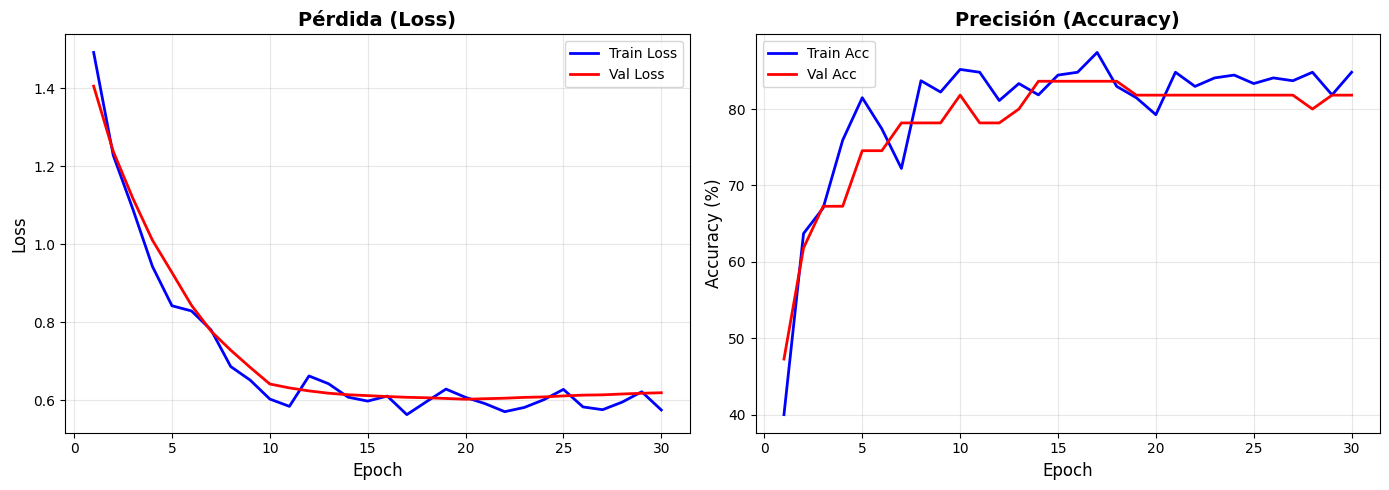

In [69]:
# Visualizar curvas de aprendizaje
plot_training_history(history_v1)

## 11. Evaluación del Modelo - Versión 1

In [70]:
# Evaluar en conjunto de prueba
print("Evaluando Modelo Versión 1 en conjunto de prueba...")
results_v1 = evaluate_model(model_v1, test_loader, device=device)

Evaluando Modelo Versión 1 en conjunto de prueba...

RESULTADOS DE EVALUACIÓN
Accuracy: 82.26%
Precision (weighted): 0.8287
Recall (weighted): 0.8226
F1-Score (weighted): 0.8240

Reporte por clase:
              precision    recall  f1-score   support

       apple       0.82      0.82      0.82        11
 pomegranate       0.92      0.92      0.92        13
       mango       0.92      0.79      0.85        14
       lemon       0.79      0.85      0.81        13
      orange       0.67      0.73      0.70        11

    accuracy                           0.82        62
   macro avg       0.82      0.82      0.82        62
weighted avg       0.83      0.82      0.82        62


RESULTADOS DE EVALUACIÓN
Accuracy: 82.26%
Precision (weighted): 0.8287
Recall (weighted): 0.8226
F1-Score (weighted): 0.8240

Reporte por clase:
              precision    recall  f1-score   support

       apple       0.82      0.82      0.82        11
 pomegranate       0.92      0.92      0.92        13
    

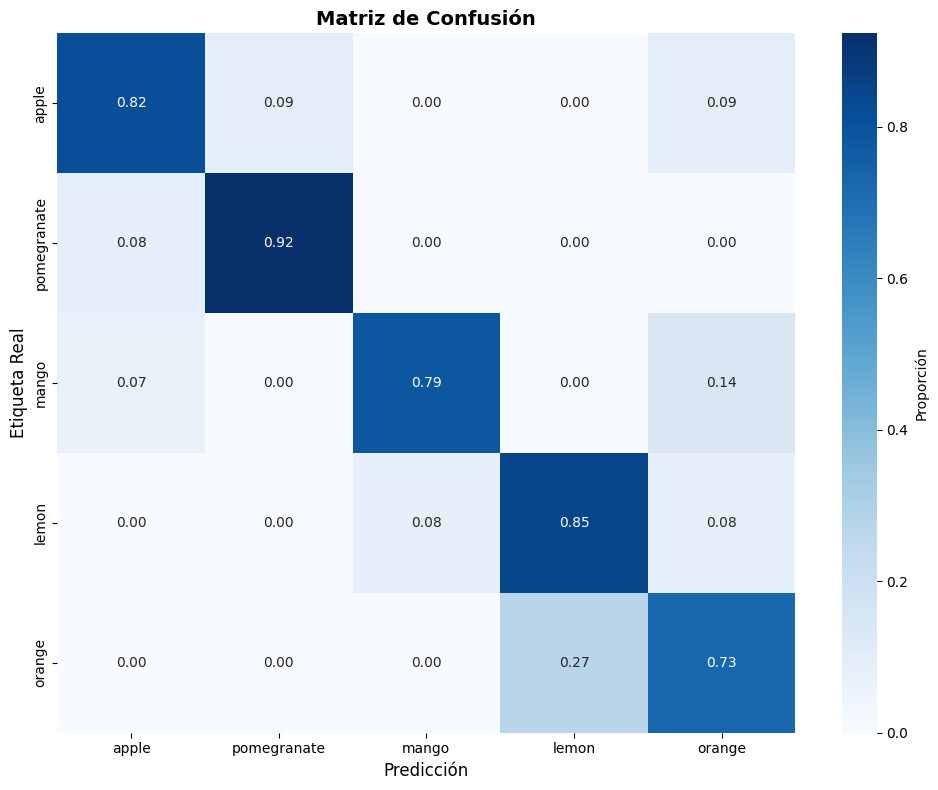

In [71]:
# Matriz de confusión
plot_confusion_matrix(results_v1['confusion_matrix'], normalize=True)

## 11. Construcción del Modelo - Versión 2 (Extendido)

Clasificador extendido con capas ocultas, Batch Normalization y Dropout.

In [72]:
# Crear modelo Versión 2
print("\nCreando Modelo Versión 2 - Clasificador Extendido")
model_v2 = create_model(variant='extended', pretrained=True)

# Verificar arquitectura
print("\nArquitectura del clasificador:")
print(model_v2.mobilenet.classifier)


Creando Modelo Versión 2 - Clasificador Extendido

Modelo creado: MobileNetV3 - Variante 'extended'
Parámetros entrenables: 658,693
Parámetros totales: 3,630,645
Porcentaje entrenable: 18.14%

Arquitectura del clasificador:
Sequential(
  (0): Linear(in_features=960, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=5, bias=True)
)


## 12. Entrenamiento del Modelo - Versión 2

In [73]:
# Configurar entrenamiento V2
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler_v2 = optim.lr_scheduler.StepLR(optimizer_v2, step_size=10, gamma=0.1)

early_stopping_v2 = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA,
    mode='min'
)

trainer_v2 = Trainer(
    model=model_v2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2,
    device=device,
    scheduler=scheduler_v2,
    early_stopping=early_stopping_v2,
    save_dir=Config.MODELS_DIR
)

In [74]:
# Entrenar modelo V2
history_v2 = trainer_v2.train(num_epochs=Config.NUM_EPOCHS, model_name='mobilenet_v3_extended')


Iniciando entrenamiento: mobilenet_v3_extended



c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\.venv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50] | Train Loss: 1.4847 | Train Acc: 35.19% | Val Loss: 1.5135 | Val Acc: 47.27%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_best.pth
Epoch [2/50] | Train Loss: 1.0383 | Train Acc: 57.78% | Val Loss: 1.1874 | Val Acc: 76.36%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_best.pth
Epoch [2/50] | Train Loss: 1.0383 | Train Acc: 57.78% | Val Loss: 1.1874 | Val Acc: 76.36%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_best.pth
Epoch [3/50] | Train Loss: 0.8888 | Train Acc: 69.26% | Val Loss: 0.8247 | Val Acc: 78.18%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_best.pth
Epoch [3/50] | Train Loss: 0.888

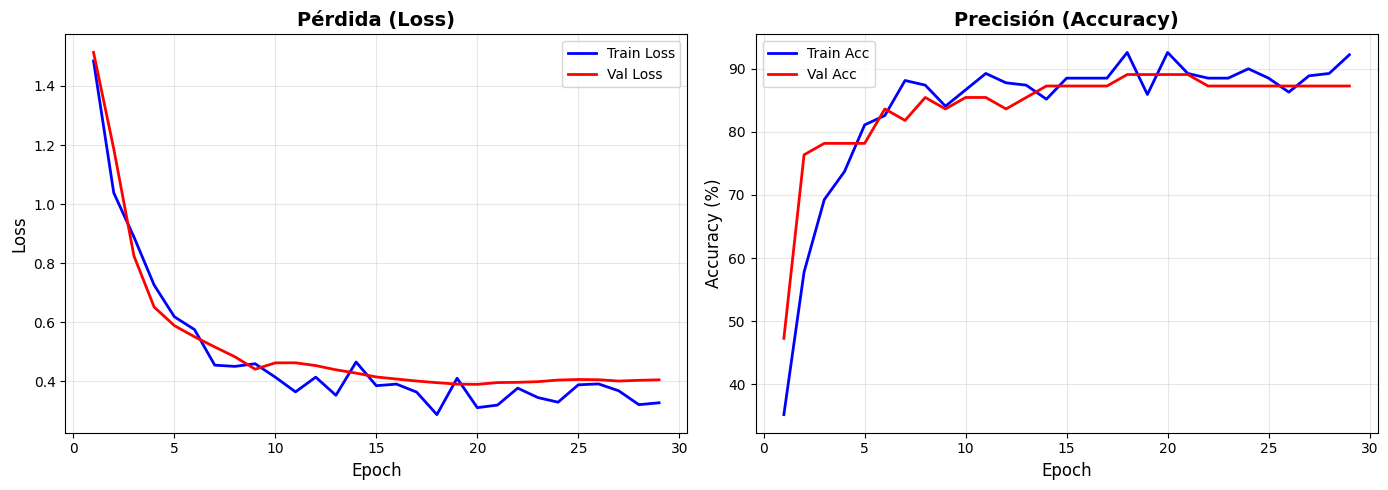

In [75]:
# Visualizar curvas de aprendizaje
plot_training_history(history_v2)

## 13. Evaluación del Modelo - Versión 2

In [76]:
# Evaluar en conjunto de prueba
print("Evaluando Modelo Versión 2 en conjunto de prueba...")
results_v2 = evaluate_model(model_v2, test_loader, device=device)

Evaluando Modelo Versión 2 en conjunto de prueba...

RESULTADOS DE EVALUACIÓN
Accuracy: 90.32%
Precision (weighted): 0.9066
Recall (weighted): 0.9032
F1-Score (weighted): 0.9037

Reporte por clase:
              precision    recall  f1-score   support

       apple       0.83      0.91      0.87        11
 pomegranate       0.92      0.92      0.92        13
       mango       1.00      0.93      0.96        14
       lemon       0.86      0.92      0.89        13
      orange       0.90      0.82      0.86        11

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.91      0.90      0.90        62



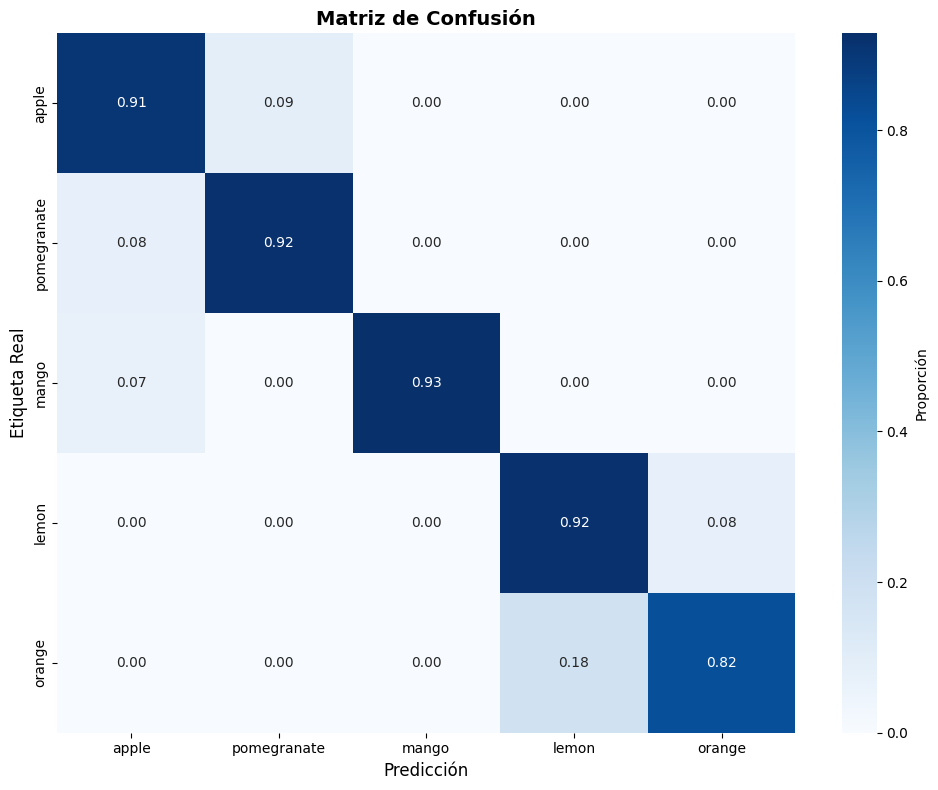

In [77]:
# Matriz de confusión
plot_confusion_matrix(results_v2['confusion_matrix'], normalize=True)

## 14. Experimento Adicional: Versión 2 sin BN ni Dropout

Para analizar el impacto de Batch Normalization y Dropout, construimos y entrenamos una variante de la Versión 2 **sin estas técnicas de regularización**.

In [78]:
# Crear Versión 2 sin BN ni Dropout
print("\nCreando Modelo Versión 2 - Sin Batch Normalization ni Dropout")

# Crear modelo base
model_v2_no_reg = create_model(variant='simple', pretrained=True)

# Crear clasificador personalizado tipo embudo SIN BN ni Dropout
import torch.nn as nn

in_features = model_v2_no_reg.mobilenet.classifier[0].in_features

# Clasificador tipo embudo: 512 → 256 → 128 → 5 (sin BN, sin Dropout)
classifier_no_reg = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, Config.NUM_CLASSES)
)

# Reemplazar el clasificador
model_v2_no_reg.mobilenet.classifier = classifier_no_reg

print("\nArquitectura del clasificador (SIN BN ni Dropout):")
print(model_v2_no_reg.mobilenet.classifier)


Creando Modelo Versión 2 - Sin Batch Normalization ni Dropout

Modelo creado: MobileNetV3 - Variante 'simple'
Parámetros entrenables: 4,805
Parámetros totales: 2,976,757
Porcentaje entrenable: 0.16%

Arquitectura del clasificador (SIN BN ni Dropout):
Sequential(
  (0): Linear(in_features=960, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=5, bias=True)
)


In [79]:
# Configurar entrenamiento para V2 sin regularización
optimizer_v2_no_reg = optim.Adam(model_v2_no_reg.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler_v2_no_reg = optim.lr_scheduler.StepLR(optimizer_v2_no_reg, step_size=10, gamma=0.1)

early_stopping_v2_no_reg = EarlyStopping(
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA,
    mode='min'
)

trainer_v2_no_reg = Trainer(
    model=model_v2_no_reg,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2_no_reg,
    device=device,
    scheduler=scheduler_v2_no_reg,
    early_stopping=early_stopping_v2_no_reg,
    save_dir=Config.MODELS_DIR
)

# Entrenar
print("\nEntrenando Versión 2 SIN BN ni Dropout...")
history_v2_no_reg = trainer_v2_no_reg.train(num_epochs=Config.NUM_EPOCHS, model_name='mobilenet_v3_extended_no_reg')


Entrenando Versión 2 SIN BN ni Dropout...

Iniciando entrenamiento: mobilenet_v3_extended_no_reg



c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\.venv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50] | Train Loss: 1.5235 | Train Acc: 40.37% | Val Loss: 1.3534 | Val Acc: 65.45%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_no_reg_best.pth
Epoch [2/50] | Train Loss: 1.0633 | Train Acc: 60.37% | Val Loss: 0.8761 | Val Acc: 65.45%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_no_reg_best.pth
Epoch [3/50] | Train Loss: 0.8940 | Train Acc: 69.63% | Val Loss: 0.8806 | Val Acc: 60.00%
Epoch [4/50] | Train Loss: 0.6480 | Train Acc: 74.44% | Val Loss: 0.5926 | Val Acc: 83.64%
  → Mejor modelo guardado: c:\Users\Jorge Soto\Desktop\Yo\Github\transfer-learning-frutas-verduras-pytorch\saved_models\mobilenet_v3_extended_no_reg_best.pth
Epoch [5/50] | Train Loss: 0.4822 | Train Acc: 82.59% | Val Loss: 0.6278 | Val Acc: 70.91%
Epoch [6/50] | Train Loss: 0.4922 | Train Acc: 81.85% | Val Loss: 0.515

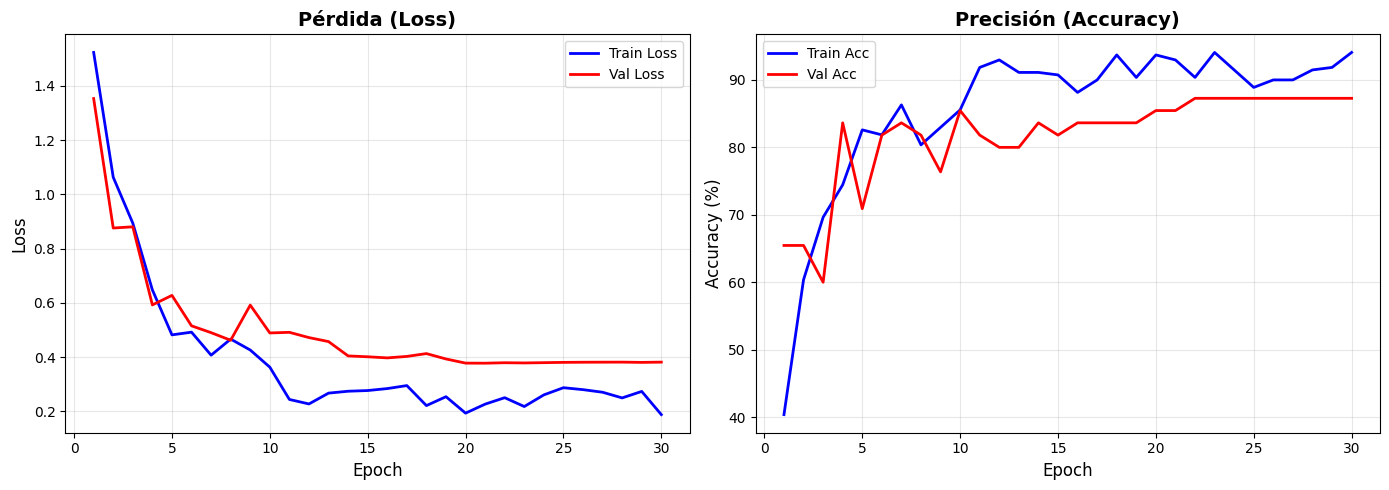

In [80]:
# Visualizar curvas de aprendizaje V2 sin regularización
plot_training_history(history_v2_no_reg)

Evaluando Modelo Versión 2 (Sin BN ni Dropout) en conjunto de prueba...

RESULTADOS DE EVALUACIÓN
Accuracy: 90.32%
Precision (weighted): 0.9059
Recall (weighted): 0.9032
F1-Score (weighted): 0.9040

Reporte por clase:
              precision    recall  f1-score   support

       apple       0.91      0.91      0.91        11
 pomegranate       1.00      0.92      0.96        13
       mango       0.93      0.93      0.93        14
       lemon       0.85      0.85      0.85        13
      orange       0.83      0.91      0.87        11

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.91      0.90      0.90        62



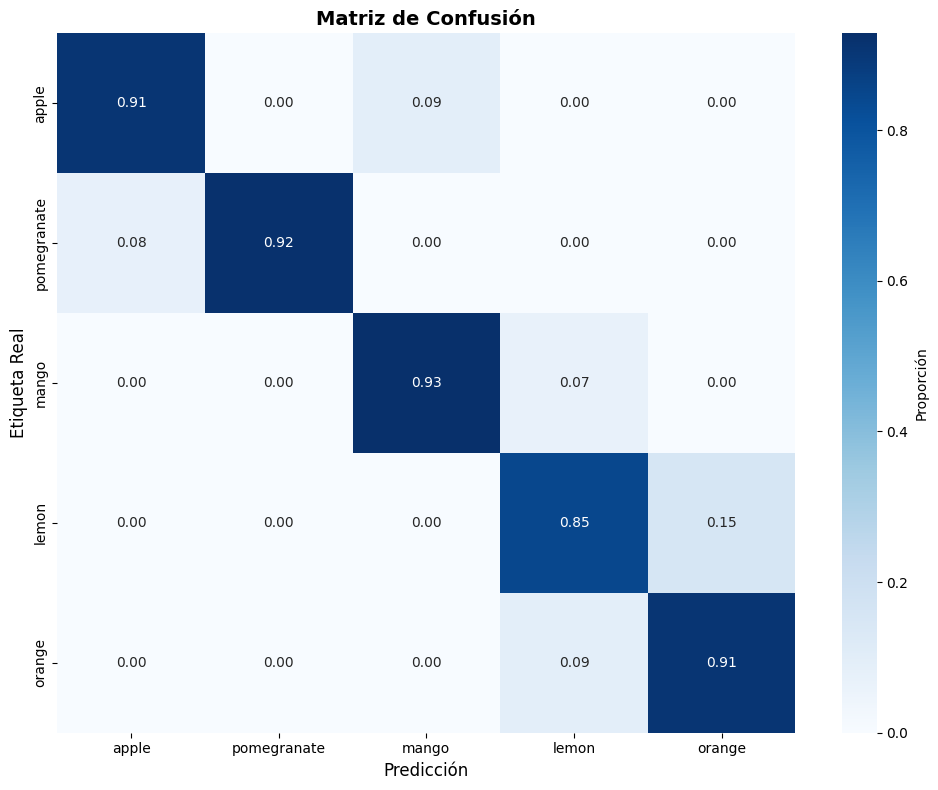

In [81]:
# Evaluar V2 sin regularización
print("Evaluando Modelo Versión 2 (Sin BN ni Dropout) en conjunto de prueba...")
results_v2_no_reg = evaluate_model(model_v2_no_reg, test_loader, device=device)

# Matriz de confusión
plot_confusion_matrix(results_v2_no_reg['confusion_matrix'], normalize=True)

## 15. Comparación de Variantes

In [ ]:
import pandas as pd

# Crear tabla comparativa de las 3 variantes
comparison = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'V1: Simple': [
        f"{results_v1['accuracy']:.4f}",
        f"{results_v1['precision_avg']:.4f}",
        f"{results_v1['recall_avg']:.4f}",
        f"{results_v1['f1_avg']:.4f}"
    ],
    'V2: Extendido (con BN+Dropout)': [
        f"{results_v2['accuracy']:.4f}",
        f"{results_v2['precision_avg']:.4f}",
        f"{results_v2['recall_avg']:.4f}",
        f"{results_v2['f1_avg']:.4f}"
    ],
    'V2: Extendido (sin BN ni Dropout)': [
        f"{results_v2_no_reg['accuracy']:.4f}",
        f"{results_v2_no_reg['precision_avg']:.4f}",
        f"{results_v2_no_reg['recall_avg']:.4f}",
        f"{results_v2_no_reg['f1_avg']:.4f}"
    ]
})

print("\n" + "="*80)
print("COMPARACIÓN DE LAS TRES VARIANTES DEL MODELO")
print("="*80)
print(comparison.to_string(index=False))
print("="*80)

# Comparación de parámetros de cada modelo
print("\n" + "="*80)
print("NÚMERO DE PARÁMETROS")
print("="*80)
print(f"V1 (Simple): {sum(p.numel() for p in model_v1.parameters()):,} parámetros")
print(f"V2 (con BN+Dropout): {sum(p.numel() for p in model_v2.parameters()):,} parámetros")
print(f"V2 (sin BN ni Dropout): {sum(p.numel() for p in model_v2_no_reg.parameters()):,} parámetros")
print("="*80)

## 17. Conclusiones y Análisis Final

## 18. Análisis de Errores de Predicción

Analicemos los errores que comete cada modelo para entender mejor su comportamiento.

In [ ]:
# Funciones auxiliares para análisis de errores

def analyze_predictions_errors(model, data_loader, device='cuda', num_samples=10):
    """
    Analiza los errores de predicción del modelo.
    
    Args:
        model: Modelo a evaluar
        data_loader: DataLoader con datos
        device: Dispositivo
        num_samples: Número de errores a mostrar
        
    Returns:
        Lista de diccionarios con información de errores
    """
    model.eval()
    model.to(device)
    
    errors = []
    class_names = Config.SELECTED_CLASSES
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            # Encontrar errores
            incorrect = predicted != labels
            
            for i in range(len(images)):
                if incorrect[i] and len(errors) < num_samples:
                    errors.append({
                        'image': images[i].cpu(),
                        'true_label': class_names[labels[i].item()],
                        'pred_label': class_names[predicted[i].item()],
                        'probability': probs[i][predicted[i]].item(),
                        'true_prob': probs[i][labels[i]].item()
                    })
            
            if len(errors) >= num_samples:
                break
    
    return errors

def denormalize_image(image, mean=None, std=None):
    """
    Desnormaliza una imagen para visualización.
    
    Args:
        image: Tensor de imagen normalizada [C, H, W]
        mean: Media usada en normalización
        std: Desviación estándar usada en normalización
        
    Returns:
        Imagen desnormalizada como numpy array [H, W, C]
    """
    if mean is None:
        mean = Config.MEAN
    if std is None:
        std = Config.STD
    
    # Clonar para no modificar el original
    img = image.clone()
    
    # Desnormalizar
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    
    # Convertir a numpy y transponer
    img = img.numpy().transpose((1, 2, 0))
    
    # Clip a rango válido
    img = np.clip(img, 0, 1)
    
    return img

def plot_prediction_errors(errors, figsize=(15, 12)):
    """
    Visualiza errores de predicción.
    
    Args:
        errors: Lista de diccionarios con información de errores
        figsize: Tamaño de la figura
    """
    num_errors = len(errors)
    cols = 3
    rows = (num_errors + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel() if num_errors > 1 else [axes]
    
    for i, error in enumerate(errors):
        if i >= len(axes):
            break
            
        img = denormalize_image(error['image'])
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"Real: {error['true_label']}\n"
            f"Pred: {error['pred_label']} ({error['probability']:.2%})\n"
            f"True prob: {error['true_prob']:.2%}",
            color='red',
            fontsize=10
        )
    
    # Ocultar ejes vacíos
    for i in range(num_errors, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def create_performance_comparison_plot(results_v1, results_v2, results_v2_no_reg=None, save_path=None):
    """
    Crea gráfico comparativo de desempeño entre variantes.
    
    Args:
        results_v1: Resultados de Versión 1
        results_v2: Resultados de Versión 2
        results_v2_no_reg: Resultados de Versión 2 sin regularización (opcional)
        save_path: Ruta para guardar (opcional)
    """
    metrics = ['accuracy', 'precision_avg', 'recall_avg', 'f1_avg']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    v1_values = [results_v1[m] for m in metrics]
    v2_values = [results_v2[m] for m in metrics]
    
    x = np.arange(len(metric_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width, v1_values, width, label='V1 (Simple)', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x, v2_values, width, label='V2 (con BN+Dropout)', color='coral', alpha=0.8)
    
    if results_v2_no_reg:
        v2_no_reg_values = [results_v2_no_reg[m] for m in metrics]
        bars3 = ax.bar(x + width, v2_no_reg_values, width, label='V2 (sin BN ni Dropout)', color='lightgreen', alpha=0.8)
    
    ax.set_xlabel('Métricas', fontsize=12)
    ax.set_ylabel('Valor', fontsize=12)
    ax.set_title('Comparación de Desempeño entre Variantes', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    # Añadir valores sobre las barras
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    if results_v2_no_reg:
        add_value_labels(bars3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Gráfico guardado en: {save_path}")
    
    plt.show()

print("✓ Funciones de análisis de errores definidas")

In [ ]:
# Analizar errores de V1
print("Analizando errores de Versión 1...")
errors_v1 = analyze_predictions_errors(model_v1, test_loader, device=device, num_samples=9)

print(f"\nSe encontraron {len(errors_v1)} errores para mostrar")
plot_prediction_errors(errors_v1)

In [ ]:
# Analizar errores de V2
print("Analizando errores de Versión 2...")
errors_v2 = analyze_predictions_errors(model_v2, test_loader, device=device, num_samples=9)

print(f"\nSe encontraron {len(errors_v2)} errores para mostrar")
plot_prediction_errors(errors_v2)

## 18. Gráfico Comparativo de Desempeño

In [ ]:
# Crear gráfico comparativo de las 3 variantes
create_performance_comparison_plot(results_v1, results_v2, results_v2_no_reg)

## 19. Resumen de Modelos y Parámetros

In [ ]:
def print_model_summary(model, model_name="Modelo"):
    """
    Imprime resumen detallado del modelo.
    
    Args:
        model: Modelo PyTorch
        model_name: Nombre del modelo
    """
    print("\n" + "=" * 80)
    print(f"RESUMEN DEL {model_name.upper()}")
    print("=" * 80)
    
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    
    print(f"\nParámetros totales: {total:,}")
    print(f"Parámetros entrenables: {trainable:,} ({100*trainable/total:.2f}%)")
    print(f"Parámetros congelados: {frozen:,} ({100*frozen/total:.2f}%)")
    
    print(f"\nArquitectura del clasificador:")
    print(model.mobilenet.classifier)
    
    print("\n" + "=" * 80)

# Mostrar resumen de cada variante
print_model_summary(model_v1, "Versión 1 - Simple")
print_model_summary(model_v2, "Versión 2 - con BN+Dropout")
print_model_summary(model_v2_no_reg, "Versión 2 - sin BN ni Dropout")